import library

In [1]:
import pandas as pd
import tensorflow as tf
import os

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3

data preparation (data sudah dibagi 80:20 manual)

In [2]:
#dir training
train_dir = '/content/drive/My Drive/catsanddogs/training_set'
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#dir test
test_dir = '/content/drive/My Drive/catsanddogs/test_set'
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

image augmentation

In [3]:
train_datagen = ImageDataGenerator(
                     rescale=1./255,
                     rotation_range=20,
                     horizontal_flip=True,
                     shear_range = 0.2,
                     fill_mode = 'nearest')
     
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

prepare training data for model training

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')
     
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=128, 
        class_mode='binary')

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


model

In [5]:
inceptionV3 = InceptionV3(include_top= False, input_shape=(150,150,3))
for layer in inceptionV3.layers:
	layer.trainable = False

87916544/87910968 [==============================] - 0s 0us/step


In [6]:
model = tf.keras.models.Sequential([
    inceptionV3, 
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

optimizer and loss function

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

callbacks

In [8]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92):
      self.model.stop_training = True

callbacks = callback()

training model

In [9]:
history = model.fit(train_generator,
                    epochs = 100,
                    verbose = 1,
                    validation_data = test_generator,
                    callbacks=[callbacks])

Epoch 1/100
63/63 [==============================] - 4619s 73s/step - loss: 0.3534 - accuracy: 0.8775 - val_loss: 0.1134 - val_accuracy: 0.9521
Epoch 2/100
63/63 [==============================] - 73s 1s/step - loss: 0.1539 - accuracy: 0.9448 - val_loss: 0.1074 - val_accuracy: 0.9624


plot accuracy

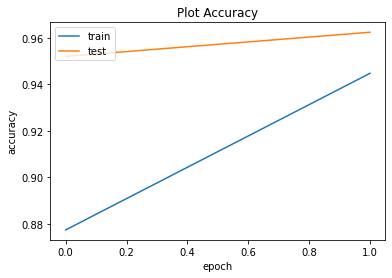

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plot loss

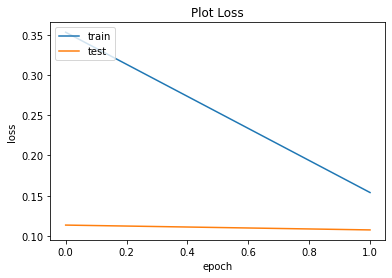

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

convert to tflite

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#menyimpan model ke model.tflite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp096tfa6b/assets
